In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#from InterNetwork import set_seed, Leg_Setup, NN_run, NN_results, Get_Num_Legs
from InterNetwork import *
from datetime import datetime
import numpy as np

from matplotlib import rc
rc("font", family="serif", size=14)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2
import pickle
from shutil import copyfile

import smtplib, ssl
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage

from neuralStellar2 import stellarGrid,NNmodel
#tf.compat.v1.enable_eager_execution()

config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
config.gpu_options.allow_growth = True

#import sys
#sys.path.append('/content/drive/My Drive/UoB physics/year 4/FYP')
#consider decreasing the learning rate the step after 0.001
"""
preventing disconnect
1. ctrl+shift+i
2. go to console
3. go to the bottom and paste:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

4. hit enter
"""

Using TensorFlow backend.


'\npreventing disconnect\n1. ctrl+shift+i\n2. go to console\n3. go to the bottom and paste:\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument.querySelector("colab-toolbar-button#connect").click() \n}\nsetInterval(ClickConnect,60000)\n\n4. hit enter\n'

In [0]:
folder_name = '146'
load_partially_trained_model = True
recompile = False #recompile rules: 1. if not list: it will always set whether to recompile to that value, 2. if list: each leg will recompile based on the corresponding recompile list elemnt, 3. if list is shorter than no. legs: for legs with indeces greater than the list, those legs will be set to not recompile unless otherwise instructed, 4. if recompile gives a leg False to but other parameter changes require it to recompile it will still recompile.
load_RGB_only = "EarlyType"
#load_RGB_only = True
poly_degree = 0 #the degree of the polynomial used to fit the RGB to scale the radius. If None or 0: skips radius scaling

hidden_layers = ['bn']+[128]*10
activation = 'elu'
mean_error_type = 'MAE'

dropout = None
decay = None
momentum = 0 #between 0 and 1, setting momentum as 0 right now doesn't effect NAdam

opt = "Nadam"
reg = [['l2',1E-6]]
epoch_no = [100,100,100,100,100,100,100,100,100,100,1000,3000]+[20000]+[2000]*12
lr = [0.0001,0.0002,0.0005,0.001,'prev']
batch_size = [1000,2000,5000,20000,50000,200000,500000,1000000,2000000,3000000]
#EarlyType points = 2659783

leg: 24/25
epochs of leg: 2000, optimizer: Nadam, activation: elu
learning rate: prev, batch size: 3000000, regularization: ['l2', 1e-06], dropout: None, mean error type: MAE
training done! now=2020-03-09 02:06:51.076112 | Time elapsed=0:27:46.463477


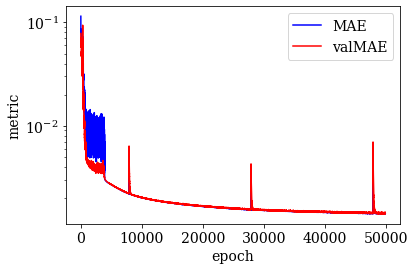

history plot saved as "drive/My Drive/4th Year Project/146/history146.png"


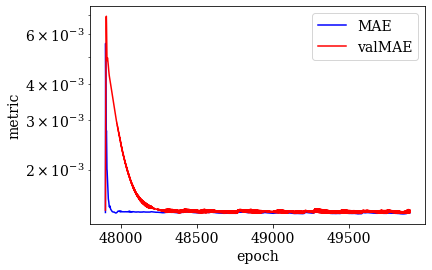

0.0014055192
leg: 25/25
epochs of leg: 2000, optimizer: Nadam, activation: elu
learning rate: prev, batch size: 3000000, regularization: ['l2', 1e-06], dropout: None, mean error type: MAE
training done! now=2020-03-09 02:34:55.529121 | Time elapsed=0:27:32.796788


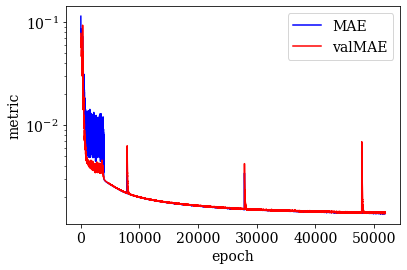

history plot saved as "drive/My Drive/4th Year Project/146/history146.png"


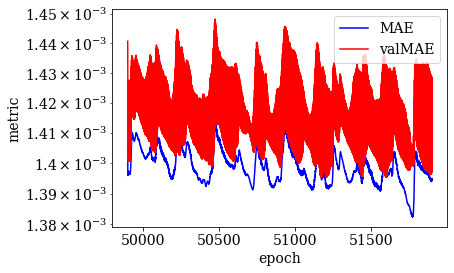

0.0013948766


In [6]:
starttime = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
legs = Leg_Setup(folder_name=folder_name,reg=reg,lr=lr,epoch_no=epoch_no,batch_size=batch_size,opt=opt,activation=activation,dropout=dropout,momentum=momentum,decay=decay,mean_error_type=mean_error_type,recompile=recompile)

if load_RGB_only == True:
  grid_file='drive/My Drive/4th Year Project/grid2_trun_RGB.csv'
elif load_RGB_only == "EarlyType":
  grid_file='drive/My Drive/4th Year Project/grid2_early.csv'
  #grid_file='drive/My Drive/4th Year Project/grid2_trun_early.csv'
else:
  grid_file='drive/My Drive/4th Year Project/grid2_trun.csv'
df = pd.read_csv(grid_file)
#######################################
#df['tenfeh'] = 10**df.star_feh # not required because already in grid
df['scale_T'] = (df.effective_T/5000) #adds additional column for experimenting
#print(df.keys())

if poly_degree != None and poly_degree != 0:
  poly_coeffs = [[10.080063081738215],[-6.299335472415236, 10.242237170209801],[-610.7218017418816, 89.85671949554772, 6.774087565549949],[16905.40447207155, -4065.6311495554132, 310.3175291041117, 2.44531045264507],[-345325.91585290496, 100978.60207855009,-11247.38751663596,559.9266166206404,-0.4452098122376857],[5477893.169557465,-1707033.133164369,221636.15660754204,-15654.177988126563,611.5582474359531,-0.31834338820664926],[-59126555.07934094,14508309.859740352,-1343909.580772016,81996.14585277902,-6402.515077045019,381.599457896548,1.3749938813434033],[-699962035.405495,430765243.7904518,-94918092.71809113,9901554.35675961,-484555.0863223898,5291.626663393838,418.7372807820708,-2.140655448794895],[82146144833.0785,-36765444489.27007,6910120364.377735,-704557665.2236683,41556469.95754824,-1336030.766888207,13441.264472906618,499.11916033295904,-3.694128400005397],[-370270824412.91266,186712010232.51346,-36545123603.61212,3601962498.6247864,-184265308.92825338,3520460.454963947,151277.9849266049,-16126.529234488851,712.3937516064432,-3.048353222993039]] #list of lists of best fit coefficients for different degree polynomials for use in radius scaling of the RGB, poly_coeffs[0] contains the best fit coefficients for a linear fit e.g. y=mx
  radius_coeffs = poly_coeffs[poly_degree-1]
  Teffs = np.array(df['effective_T'].values.tolist())
  Delnus = np.array(df['delta_nu'].values.tolist())
  truths = np.logical_and(Teffs<10**3.72, Delnus<100)
  df['scale_radius'] = df['radius']/10**(NNmodel.polynomial(3.72-np.log10(df['effective_T']),radius_coeffs)*truths)
else:
  radius_coeffs = None

df = df.sample(frac=1).reset_index(drop=True)
NNmodel.set_seed = set_seed

for leg in range(Get_Num_Legs_Trained(folder_name=folder_name,load_partially_trained_model=load_partially_trained_model),len(legs)):
    print("leg: {}/{}\nepochs of leg: {}, optimizer: {}, activation: {}\nlearning rate: {}, batch size: {}, regularization: {}, dropout: {}, mean error type: {}".format(leg+1,len(legs),legs[leg]['epoch_no'],legs[leg]['opt'],legs[leg]['activation'],legs[leg]['lr'],legs[leg]['batch_size'],legs[leg]['reg'],legs[leg]['dropout'],legs[leg]['mean_error_type'])) 
    start_epoch, m1 = NN_run(folder_name=folder_name, df=df, hidden_layers=hidden_layers, legs=legs, leg=leg)
    if leg == len(legs)-1:
      #m1 = NN_results(last_leg = True, grid_file=grid_file,folder_name=folder_name, starttime=starttime,start_epoch=start_epoch, radius_coeffs=radius_coeffs)
      m1 = NN_results(last_leg = False, grid_file=grid_file,folder_name=folder_name, starttime=starttime,start_epoch=start_epoch, radius_coeffs=radius_coeffs)
    else:
      m1 = NN_results(last_leg = False, grid_file=grid_file,folder_name=folder_name, starttime=starttime,start_epoch=start_epoch, radius_coeffs=radius_coeffs)

In [0]:
a = []
while(1):
    a.append('1')